In [1]:

# coding: utf-8



In [2]:


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))




In [1]:


import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# DEBUG MODE:
# ROOT_DIR = os.path.abspath("/Users/AsherYartsev/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# get_ipython().run_line_magic('matplotlib', 'inline')

#asher todo: change later to path inside cucu_train
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

print(ROOT_DIR)

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
  




/Users/AsherYartsev/Mask_RCNN


Using TensorFlow backend.


In [2]:


class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cucumbers"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    #IMAGES_PER_GPU = 8
    IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shape (cucumber)

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    
    # anchor side in pixels, for each of RPN layer
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  
       
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    
    #asher todo: can we utilize it better?
    #ROI_POSITIVE_RATIO = 66  
    
    #asher todo: enlarge to 100 when real training occures
    STEPS_PER_EPOCH = 1

    VALIDATION_STEPS = 1
    
config = ShapesConfig()
config.display()





Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [3]:


def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax




In [4]:


def rotate_bound(image, angle):
    '''
    input:
        image - image with attribute shape contating height and width
        angle - rotation angle in degrees
    
    returns rotated image.
    '''
    # grab the dimensions of the image and then determine the
    # center
    # first 2 avlues of shape are height,width
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))


def add_image(img1, img2, x_center, y_center, x_scale, y_scale, angle):
    """
    name I gave: pasteImageOnOther ruined the overriding of base class function
    pasting re-scaled image on other image (collage effect)
    """
    img2 = img2.resize((int(x_scale*img2.size[0]),int(y_scale*img2.size[1])), Image.ANTIALIAS)

    img2 = img2.rotate(angle, resample=Image.BICUBIC, expand=True)
    

    rows,cols,channels = np.asarray(img2).shape
    x_from = x_center - math.floor(cols/2.)
    y_from = y_center - math.floor(rows/2.)

    img1.paste(img2, (x_from, y_from), img2)

    return img1

def add_imageWithoutTransparency(img1, img2, x_center, y_center, x_scale, y_scale, angle):
    """
    pasting re-scaled image on other image (collage effect) without transparency
    """
    
    img2 = cv2.resize(img2,None,fx=x_scale, fy=y_scale, interpolation = cv2.INTER_CUBIC)

    #Rotate
    img2 = rotate_bound(img2, 360-angle)
    
    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    x_from = x_center - math.floor(cols/2.)
    x_to = x_center + math.ceil(cols/2.)
    y_from = y_center - math.floor(rows/2.)
    y_to = y_center + math.ceil(rows/2.)
    
    y_max, x_max, _ = img1.shape
    
    #cases image out of bg image
    if x_from < 0:
        img2 = img2[:,-x_from:]
        x_from = 0
    if x_to >= x_max:
        img2 = img2[:,:-(x_to-x_max+1)]
        x_to = x_max-1
    if y_from < 0:
        img2 = img2[-y_from:,:]
        y_from = 0
    if y_to >= y_max:
        img2 = img2[:-(y_to-y_max+1),:]
        y_to = y_max-1
    
    roi = img1[y_from:y_to, x_from:x_to]

    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 1, 255, cv2.THRESH_BINARY)
    #TODO use my mask
    #mask = image_to_mask(img2)
    mask_inv = cv2.bitwise_not(mask)
    # Now black-out the area of logo in ROI
    img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    # Put logo in ROI and modify the main image
    #print(img1.shape)
    #print(img2.shape)
    dst = cv2.add(img1_bg,img2_fg[:,:,0:3])
    img1[y_from:y_to, x_from:x_to] = dst
    return img1

def image_to_mask(image):
    mask = np.zeros_like(image)
    while not np.any(mask):
        color = (0, 0, 0)
        distance = np.sum(image, axis=-1)
        mask = distance > 0
    return mask

def mask_to_image(mask):
    x,y,z = mask.shape
    image = np.zeros((x,y))
    for i in range(0,z):
        image += mask[:,:,i]*(i+1)
    print(z)
    return image




In [5]:




minimum_number_of_cucumbers = 10
maximum_number_of_cucumbers = 120
#number_of_cucumbers = 4
min_scale = 0.4
max_scale = 1.1


class CucuDataset(utils.Dataset):
    def __init__(self, folder_objects, folder_bgs):
        """
        self variables:
            folder_object - folder containing object asher todo: what is exactly an object? image +annotations?
            folder_bgs - todo: TBD
            img2 - container for all images in dataSet containing objects
            bg - container for all images in dataSet containing backGrounds
        """
        utils.Dataset.__init__(self)
        
        self.folder_objects = folder_objects
        self.folder_bgs = folder_bgs
        self.img2 = []
        self.bg = []
        for root, _, files in os.walk(self.folder_objects):
            for filename in files:
                #self.img2.append(cv2.cvtColor(cv2.imread(os.path.join(root, filename)), cv2.COLOR_BGR2RGB))
                self.img2.append(Image.open(os.path.join(root, filename)).convert('RGBA'))
        _, _, files_objects = next(os.walk(self.folder_objects))
        self.number_of_cucumbers = len(files_objects)
                
        for root, _, files in os.walk(self.folder_bgs):
            for filename in files:
                #self.bg.append(cv2.cvtColor(cv2.imread(os.path.join(root, filename)), cv2.COLOR_BGR2RGB))
                self.bg.append(Image.open(os.path.join(root, filename)).convert('RGBA'))
        _, _, files_bgs = next(os.walk(self.folder_bgs))
        self.number_of_bgs = len(files_bgs)
        print("folder: " + folder_objects + " inited")
        print("folder: " + folder_bgs + " inited")

    
    def load_shapes(self, count, height, width):
        """
        Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """

        # Add classes
        self.add_class("shapes", 1, "cucumber")
       
        # Add images
        for i in range(count):
            print('Image', i, end='\r')
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None, width=width, height=height, bg_color=bg_color, shapes=shapes)
            
    def load_image(self, image_id):
        """
        for now we only have one shape- cucumber.
        function creates 'collage' bg+one image.

        function is called by load_image_gt - it is crucial for generating on-the-fly training set 
        for NN.
        """
        info = self.image_info[image_id]
        
        index = random.randint(0, self.number_of_bgs-1) 
        
        y_max, x_max,channels = np.asarray(self.bg[index]).shape

        
        x = random.randint(0, x_max-1024)
        y = random.randint(0, y_max-1024)
        
        #image = self.bg[index][y:y+1024, x:x+1024,:]
        area = (x, y, x+1024, y+1024)
        image = self.bg[index].crop(area)
        
        for shape, location, scale, angle, index in info['shapes']:
            image = self.draw_shape(image, shape, location, scale, angle, index)
        npImage = np.array(image)
        # remove transparency channel to fit to network data
        ImageWithoutTransparency = npImage[:,:,:3]
        return ImageWithoutTransparency
    
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    
    
    def createMaskedImageByIndex(self, mask, shape, location, scale, angle, index):
        """
        function takes an image from self.img2[index] and pastes it on a given mask
        """
        x_location, y_location = location
        x_scale, y_scale = scale
        
        fig, (ax1, ax2) = plt.subplots(1,2)

        
        img2 = self.img2[index]
        ax1.imshow(img2)

        img1 = mask
        img2 = cv2.resize(img2,None,fx=x_scale, fy=y_scale, interpolation = cv2.INTER_CUBIC)

        # I want to put logo on top-left corner, So I create a ROI
        rows,cols,channels = img2.shape

        #Rotate
        img2 = rotate_bound(img2, angle)

        #ax2.imshow(mask, cmap='gray')
        
        ax2.imshow(img2)

        
        roi = img1[y_location:rows+y_location, x_location:cols+x_location ]

        # Now create a mask of logo and create its inverse mask also
        img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(img2gray, 1, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)
        # Now black-out the area of logo in ROI
        img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
        # Take only region of logo from logo image.
        img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
        # Put logo in ROI and modify the main image
        dst = cv2.add(img1_bg,img2_fg)
        img1[y_location:rows+y_location, x_offset:cols+x_location ] = dst
        
        x_location, y_location = location
        x_scale, y_scale = scale
        mask = add_image(mask, self.img2[index], x_location, y_location, x_scale, y_scale, angle)
        return mask
    
    def draw_shape_without_transparency(self, image, shape, location, scale, angle, index):
        """Draws a shape from the given specs."""
        if shape == 'cucumber':
            x_location, y_location = location
            x_scale, y_scale = scale
            image = add_imageWithoutTransparency(image, np.array(self.img2[index]),                                                             x_location, y_location, x_scale, y_scale, angle)
        return image


    def draw_shape(self, Collage, shape, location, scale, angle, index):
        """
        Draws another cucumber on a selected background
        Get the center x, y and the size s
        x, y, s = dims
        """
        

        if shape == 'cucumber':
            #print("leaf added")
            #i=0
            x_location, y_location = location
            x_scale, y_scale = scale
            #print(type(self.img2[index]))
            Collage = add_image(Collage, self.img2[index], x_location, y_location, x_scale, y_scale, angle)
        # asher todo: else?
        return Collage
    
    
    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["cucumber"])
        # Color
        # TopLeft x, y
        x_location = random.randint(0, height)
        y_location = random.randint(0, width)
        # Scale x, y
        x_scale = random.uniform(min_scale, max_scale)
        y_scale = random.uniform(min_scale, max_scale)
        # Angle
        angle = random.randint(0, 359)
        # Image index
        index = random.randint(0, self.number_of_cucumbers-1)
        
        return shape, (x_location, y_location), (x_scale, y_scale), angle, index
    
    # asher note: we don't use this func. for now
    def random_image_opencv(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        indexes  = []
        N = random.randint(minimum_number_of_cucumbers, maximum_number_of_cucumbers)
        
        image = np.ones([height, width, 3], dtype=np.uint8)
        
        for _ in range(N):
            shape, location, scale, angle, index = self.random_shape(height, width)
            
            image = add_image(image, self.img2[index], location[0], location[1], scale[0], scale[1], angle)
            y, x, _ = self.img2[index].shape
            
            #shapes.append((shape, color, dims))
            shapes.append((shape, location, scale, angle, index))
            #TODO boxes
            #x, y, s = dims
            #boxes.append([y-s, x-s, y+s, x+s])
            boxes.append([location[1], location[0], location[1] + y, location[0] + x])
            
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes
    
    
    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        indexes  = []
        N = random.randint(minimum_number_of_cucumbers, maximum_number_of_cucumbers)
            
        for _ in range(N):
            shape, location, scale, angle, index = self.random_shape(height, width)
            # asher todo: do we need this?
            #image = add_image(image, self.img2[index], location[0], location[1], scale[0], scale[1], angle)
            #y, x, _ = self.img2[index].shape
            y, x,channels = np.asarray(self.img2[index]).shape
            shapes.append((shape, location, scale, angle, index))
            #TODO boxes
            #x, y, s = dims
            #boxes.append([y-s, x-s, y+s, x+s])
            boxes.append([location[1], location[0], location[1] + y, location[0] + x])
            
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes
    
    def load_mask(self, image_id):
        """
        Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)        

        #asher note: for now itterates only once on cucumber shape
        for i, (shape, location, scale, angle, index) in enumerate(info['shapes']):
            image = np.zeros([info['height'], info['width'], 3], dtype=np.uint8)
            #for now we save in temp for easier inspection
            temp = image_to_mask(self.draw_shape_without_transparency(image, shape, location, scale, angle, index))
            #np.set_printoptions(threshold=np.nan)
            mask[:, :, i] = temp[:,:]
            
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        
        #print(occlusion)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
       
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)        




In [8]:



# Training dataset

# DEBUG MODE:
# dataset_train = CucuDataset('/Users/AsherYartsev/Mask_RCNN/cucu_train/object_folder','/Users/AsherYartsev/Mask_RCNN/cucu_train/background_folder')
# REGULAR MODE:
dataset_train = CucuDataset('./object_folder','./background_folder')

# asher todo: validation data might crossover training data due to random image picking of load_shapes
dataset_train.load_shapes(10, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()
print(np.asarray(dataset_train.bg[2]).shape)



# Validation dataset

# DEBUG MODE:
# dataset_train = CucuDataset('/Users/AsherYartsev/Mask_RCNN/cucu_train/object_folder','/Users/AsherYartsev/Mask_RCNN/cucu_train/background_folder')
# REGULAR MODE:
dataset_val = CucuDataset('./object_folder','./background_folder')

dataset_val.load_shapes(10, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()




folder: ./object_folder inited
folder: ./background_folder inited
(1800, 2880, 4)
folder: ./object_folder inited
folder: ./background_folder inited


(1024, 1024, 3)


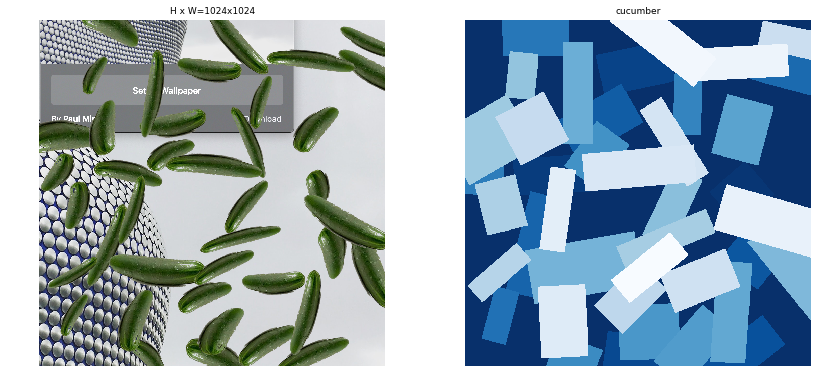

(1024, 1024, 3)


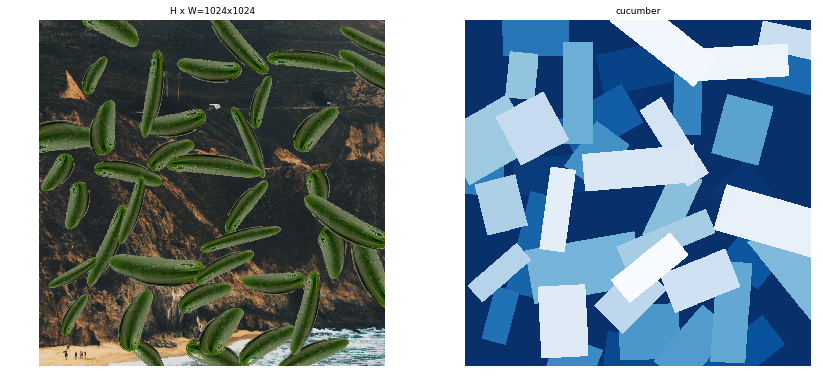

(1024, 1024, 3)


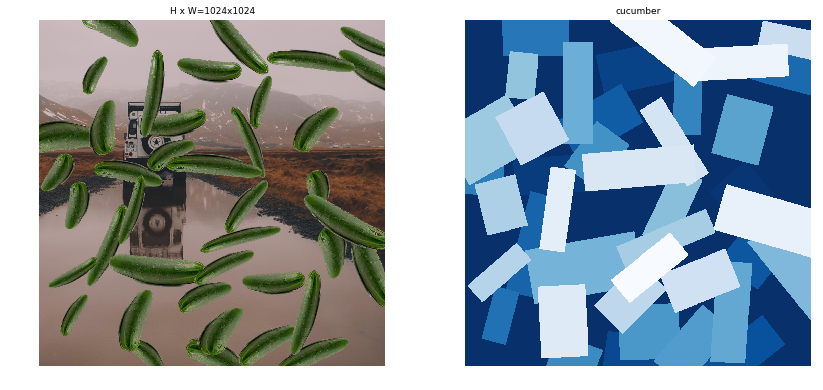

(1024, 1024, 3)


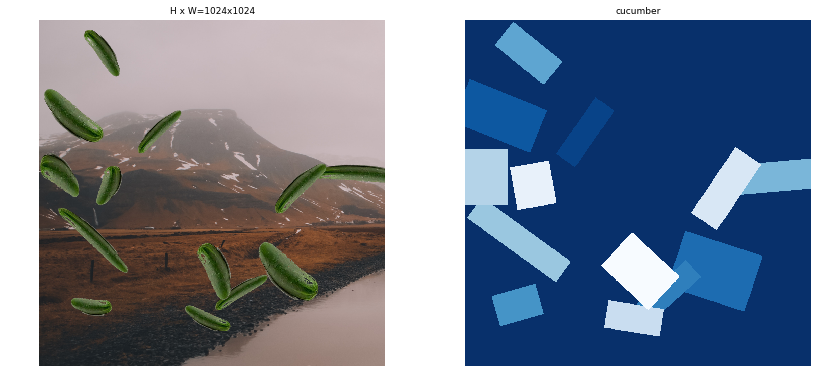

(1024, 1024, 3)


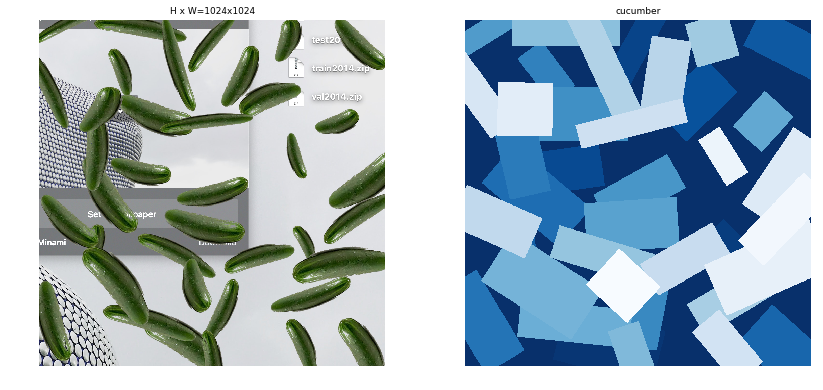

In [9]:


#show n random image&mask train examples
n = 5
image_ids = np.random.choice(dataset_train.image_ids, n)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, 1)




33


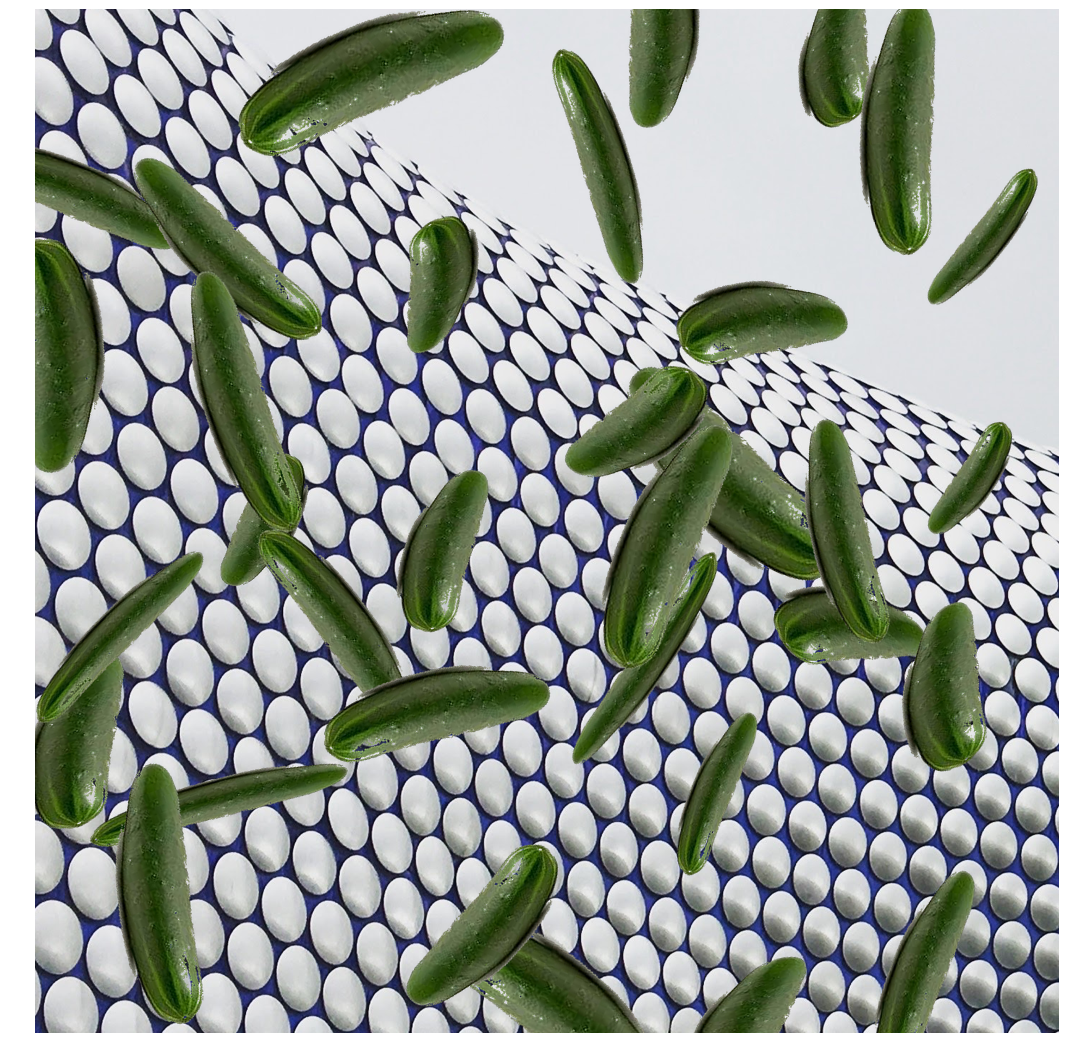

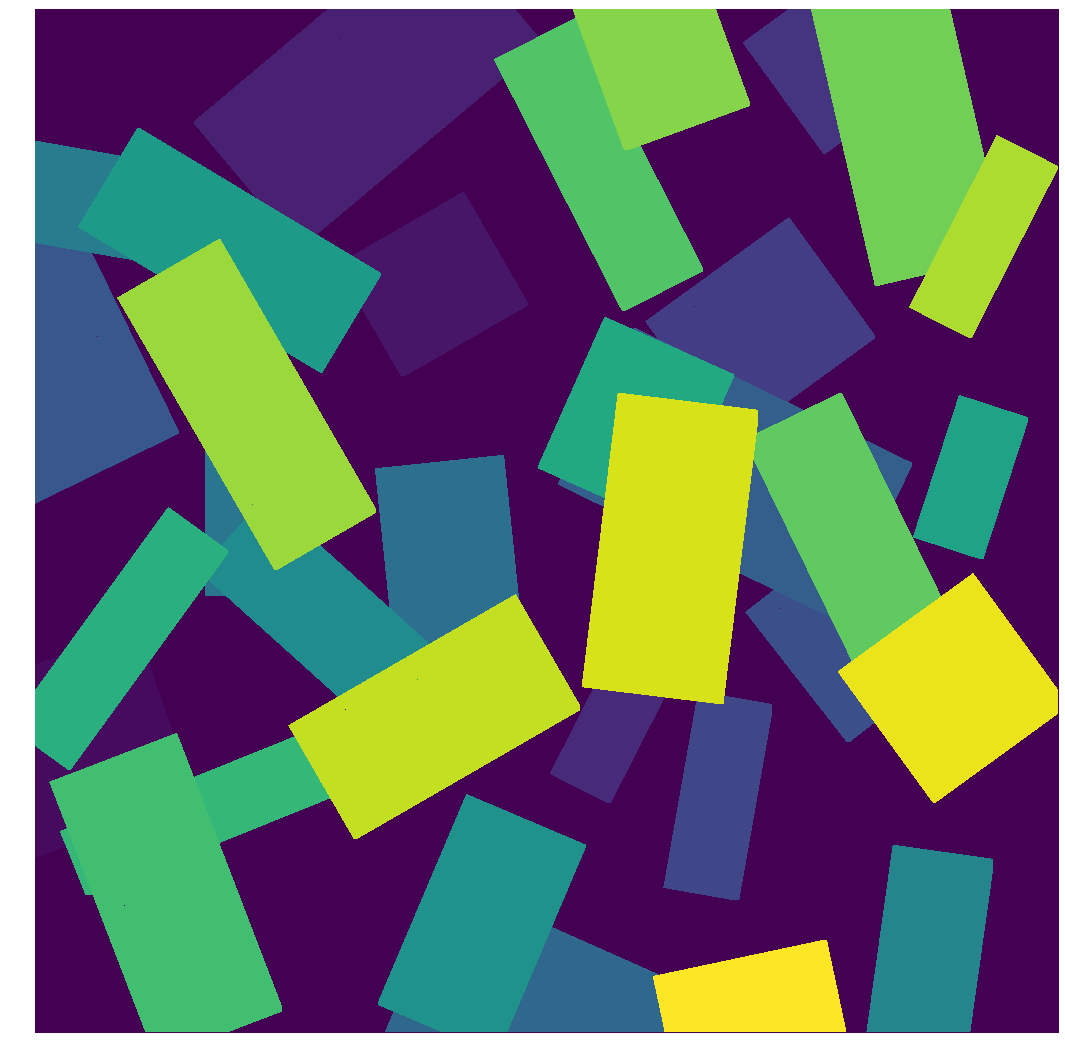

In [10]:




w = 16
h = 16


n = 1
image_ids = np.random.choice(dataset_train.image_ids, n)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    
    fig = plt.figure(frameon=False, dpi=64)
    fig.set_size_inches(w,h)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    plt.imshow(image)
    fig.savefig(ROOT_DIR + '/cucu_train/peekOnDatasetSamples/' + str(image_id) + '.png') 
    
    
    fig = plt.figure(frameon=False, dpi=64)
    fig.set_size_inches(w,h)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    plt.imshow(mask_to_image(mask))
    fig.savefig('/Users/AsherYartsev/Desktop' + str(image_id) + '.png')

    plt.show()
    





In [11]:


# Create model in training mode
print(MODEL_DIR)
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)




/Users/AsherYartsev/Mask_RCNN/logs


In [12]:


# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_by_name('/media/master/96DAE970DAE94CD5/Results/Project07 - MaskRCNN/shapes20181015T1115/mask_rcnn_shapes_1517.h5'), by_name=True)




In [13]:


# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
#model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')




In [14]:


model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE / 5, epochs=1, layers="all")





Starting at epoch 0. LR=0.0002

Checkpoint Path: /Users/AsherYartsev/Mask_RCNN/logs/cucumbers20181205T1415/mask_rcnn_cucumbers_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Con

/Users/AsherYartsev/anaconda3/envs/cucuEnv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
1/1 [==============================] - 55s 55s/step - loss: 2.1255 - rpn_class_loss: 0.2772 - rpn_bbox_loss: 1.4007 - mrcnn_class_loss: 0.4476 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 4.7671 - val_rpn_class_loss: 0.4256 - val_rpn_bbox_loss: 2.1732 - val_mrcnn_class_loss: 0.6128 - val_mrcnn_bbox_loss: 0.8314 - val_mrcnn_mask_loss: 0.7242


In [15]:


# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "cucuWheights.h5")
model.keras_model.save_weights(model_path)




In [16]:


class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()

# asher note: adding here: by_name=True, solved
# a mismatch between weights and layers - peep later on it
model.load_weights(filepath=MODEL_DIR + '/cucuWheights.h5',by_name=True)

# asher todo: resolve it later, why Dima made another loading

# # Load trained weights
# print("Loading weights from ", model_path)
# model.load_weights(model_path, by_name=True)




3
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  239.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  int64
gt_class_id              shape: (39,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (39, 4)               min:    0.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 39)      min:    0.00000  max:    1.00000  bool


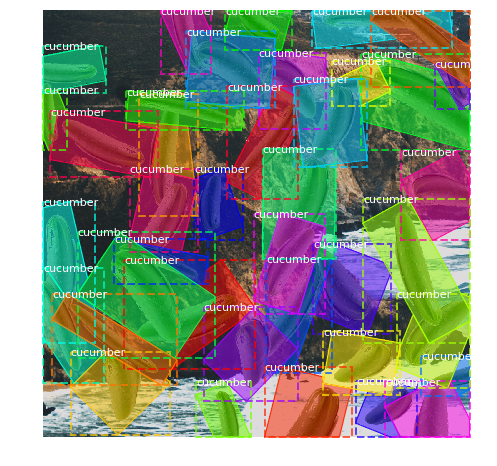

In [17]:


# Test on a random image
image_id = random.choice(dataset_val.image_ids)
print(image_id)
#image_id = 1
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))




In [18]:

#asher todo: put here random valid cucumbers img path to test net

# t = cv2.cvtColor(cv2.imread('/home/master/Work/Tensorflow/Project07 - MaskRCNN/data/results/N08/bananas/bananas_02.jpg'), cv2.COLOR_BGR2RGB)
# #original_image.shape
# results = model.detect([t], verbose=1)
#
# r = results[0]
# visualize.display_instances(t, r['rois'], r['masks'], r['class_ids'], dataset_train.class_names, r['scores'], ax=get_ax())
# # visualize.save_instances(t, r['rois'], r['masks'], r['class_ids'], dataset_train.class_names, r['scores'], ax=get_ax(), save_to='/media/global/gip-main/data/Dmitry/temp/result_0150_bananas.png')
# t= dataset_train.class_names
# print(t)




In [19]:


#from os import walk
#from os import listdir

# asher todo: figure out later what it does

# model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
# # Recreate the model in inference mode
# mypath = '/home/master/Work/logs/shapes20180826T1036/'
# mypath_out = '/home/master/Work/logs/temp_out/'

# # Get path to saved weights
# # Either set a specific path or find last trained weights
# # model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# #model_path = model.find_last()


# t = cv2.cvtColor(cv2.imread('/home/master/Work/Tensorflow/Project07 - MaskRCNN/data/results/N09/avocado/2018-06-21_AV_leaves_01_1024_02.jpg'), cv2.COLOR_BGR2RGB)
# #original_image.shape



# #f = []
# #for (dirpath, dirnames, filenames) in walk(mypath):
# #    print(os.path.join(mypath,filenames))
#     #f.extend(filenames)
#     #break
    
# for filename in sorted(os.listdir(mypath)):
    
#     full_name = os.path.join(mypath,filename)
#     model_path = model.find_by_name(full_name)
#     # Load trained weights
#     print("Loading weights from ", model_path)
#     model.load_weights(model_path, by_name=True)
    
#     results = model.detect([t], verbose=1)

#     r = results[0]
#     base = os.path.splitext(filename)[0]
#     image_name = base + ".png"
    
#     visualize.save_instances(t, r['rois'], r['masks'], r['class_ids'], dataset_train.class_names, r['scores'], ax=get_ax(), save_to=os.path.join(mypath_out, image_name))




Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  239.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  134.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


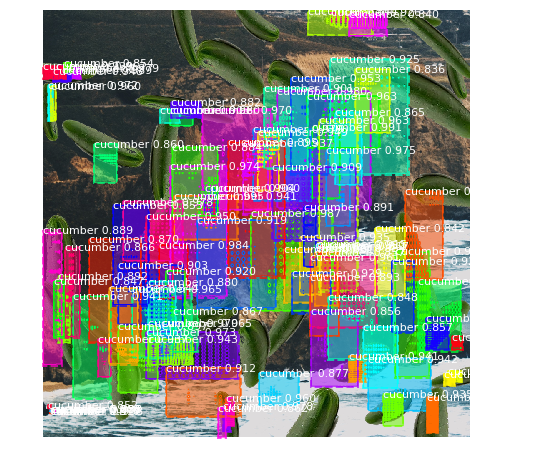

In [20]:


results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())




In [21]:

#asher todo: use this information later when relevant for fine tuning

# # Compute VOC-Style mAP @ IoU=0.5
# # Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 100)
# APs = []
# for image_id in image_ids:
#     # Load image and ground truth data
#     image, image_meta, gt_class_id, gt_bbox, gt_mask =        modellib.load_image_gt(dataset_val, inference_config,
#                                image_id, use_mini_mask=False)
#     molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
#     # Run object detection
#     results = model.detect([image], verbose=0)
#     r = results[0]
#     # Compute AP
#     AP, precisions, recalls, overlaps =        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                          r["rois"], r["class_ids"], r["scores"], r['masks'])
#     APs.append(AP)
    
# print("mAP: ", np.mean(APs))

